In [5]:
import pandas as pd
import numpy as np
import scipy as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Read in the Students data file
df_total = pd.read_csv('NCHS_-_Leading_Causes_of_Death__United_States.csv')

# Exclude rows where the 'State' column is "United States"
df = df[df_total['State'] != 'United States']

# View the first few rows of the dataset
df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2703,53.8
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4184,56.2
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1625,51.8
5,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,California,13840,33.2


In [12]:
# Calculate summary statistics
df.describe().round(2)

,Year,Deaths,Age-adjusted Death Rate
count,10659.00,10659.00,10659.00
mean,2008.00,7881.52,127.60
std,5.48,21021.08,223.74
min,1999.00,21.00,2.60
25%,2003.00,599.50,19.20
50%,2008.00,1668.00,35.80
75%,2013.00,5091.50,151.45
max,2017.00,268189.00,1087.30


In [13]:
# Filter for the most recent year
recent_year = df['Year'].max()
df_recent = df[df['Year'] == recent_year]

# Group by 'State' and 'Cause Name' and sum the 'Deaths'
state_cause_deaths = df_recent.groupby(['State', 'Cause Name'])['Deaths'].sum().reset_index()

# Determine the leading cause of death for each state
idx = state_cause_deaths.groupby('State')['Deaths'].idxmax()
leading_causes = state_cause_deaths.loc[idx]

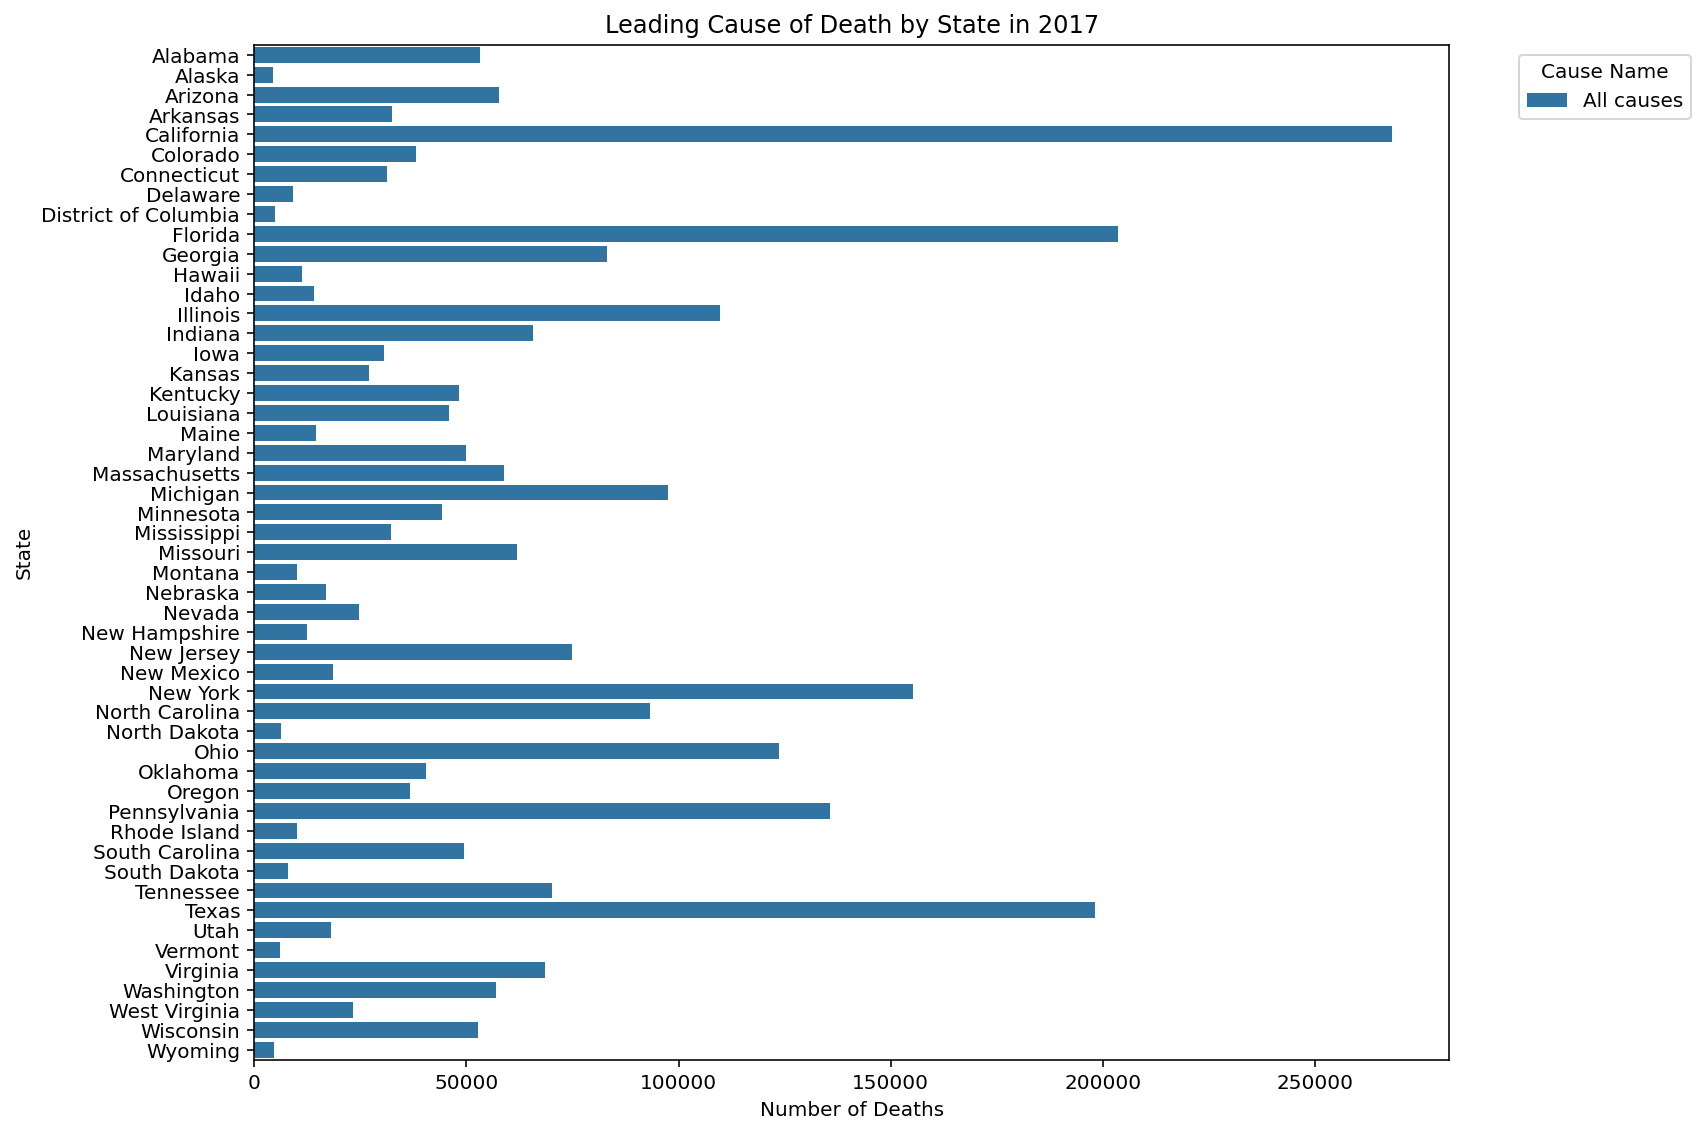

In [14]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(data=leading_causes, x='Deaths', y='State', hue='Cause Name', dodge=False)

# Add titles and labels
plt.title(f'Leading Cause of Death by State in {recent_year}')
plt.xlabel('Number of Deaths')
plt.ylabel('State')

# Display the legend outside the plot
plt.legend(title='Cause Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

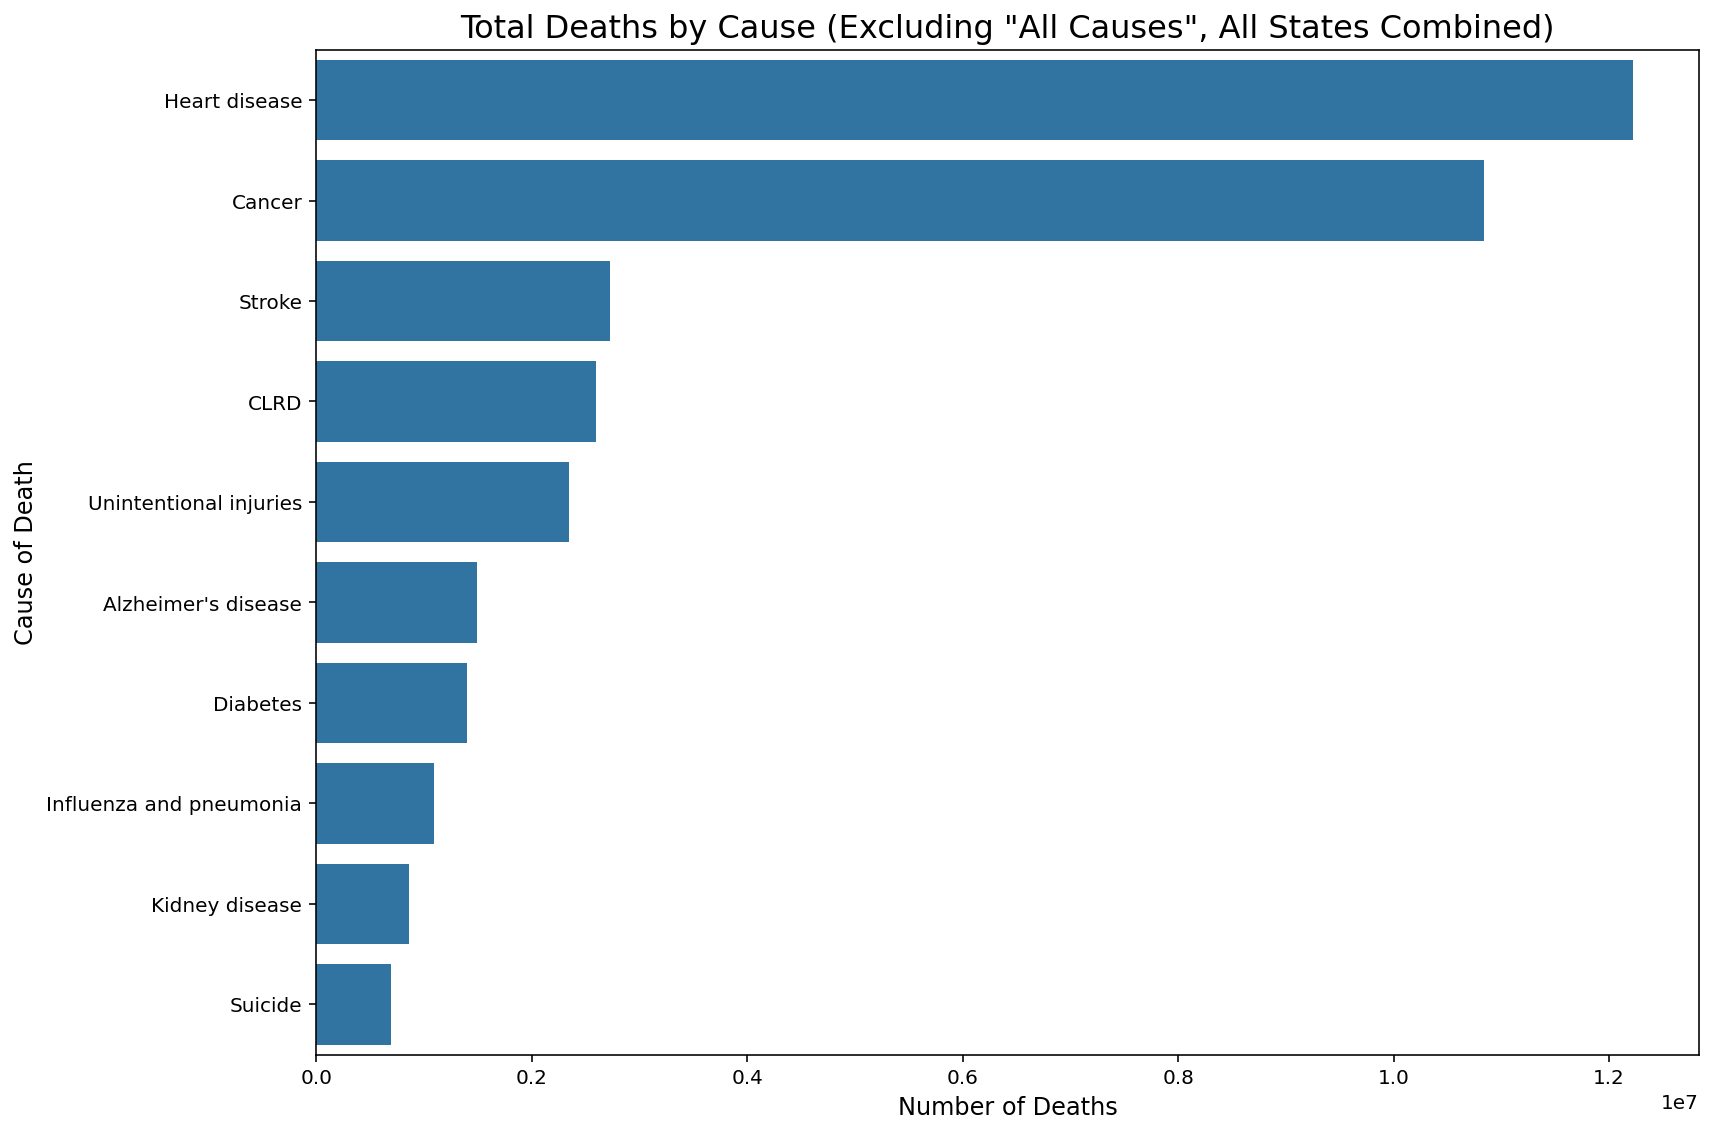

In [26]:
# Drop rows where 'Cause Name' is "All Causes" (case insensitive and whitespace handled)
df_filtered = df[df['Cause Name'].str.strip().str.lower() != 'all causes']

# Aggregate deaths by cause
cause_deaths = df_filtered.groupby('Cause Name')['Deaths'].sum().reset_index()

# Sort by the number of deaths
cause_deaths = cause_deaths.sort_values(by='Deaths', ascending=False)

# Handle missing data (depending on context)
cause_deaths = cause_deaths.dropna()  # Remove any rows with NaN values

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(data=cause_deaths, x='Deaths', y='Cause Name')

# Add titles and labels
plt.title('Total Deaths by Cause (Excluding "All Causes", All States Combined)', fontsize=16)
plt.xlabel('Number of Deaths', fontsize=12)
plt.ylabel('Cause of Death', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

<Figure size 1008x576 with 0 Axes>

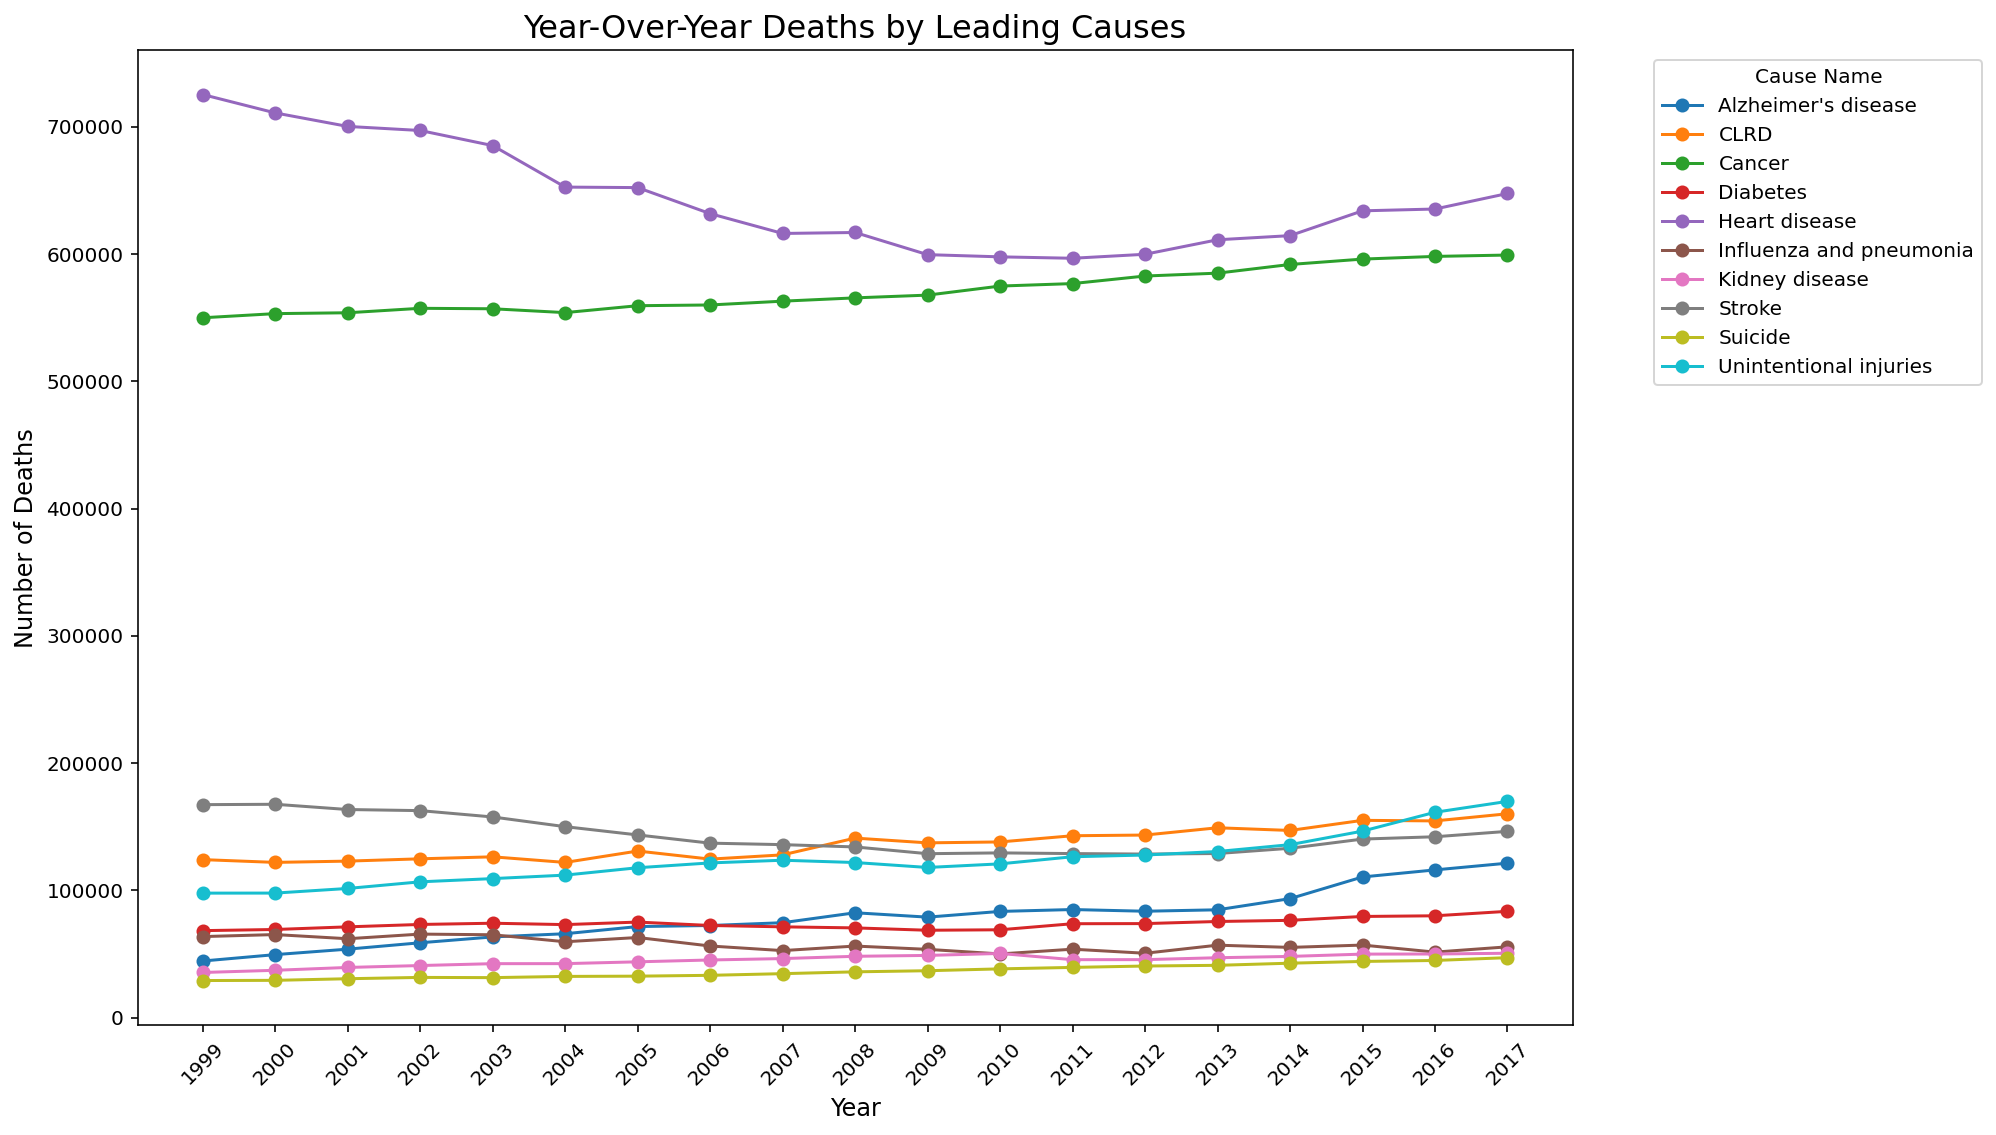

In [28]:
# Aggregate deaths by year and cause
yearly_cause_deaths = df_filtered.groupby(['Year', 'Cause Name'])['Deaths'].sum().reset_index()

# Sort causes by total deaths across all years for better visualization
top_causes = yearly_cause_deaths.groupby('Cause Name')['Deaths'].sum().nlargest(10).index
yearly_cause_deaths = yearly_cause_deaths[yearly_cause_deaths['Cause Name'].isin(top_causes)]

# Pivot data for line plot
pivot_data = yearly_cause_deaths.pivot(index='Year', columns='Cause Name', values='Deaths')

# Plot the data
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='line', marker='o', figsize=(14, 8))

# Add titles and labels
plt.title('Year-Over-Year Deaths by Leading Causes', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Deaths', fontsize=12)
plt.xticks(ticks=pivot_data.index, labels=pivot_data.index, rotation=45)  # Individual labels for each year
plt.legend(title='Cause Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()